In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
!wget https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/retail_sales.csv

--2021-12-10 08:03:05--  https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/retail_sales.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5279 (5.2K) [text/plain]
Saving to: ‘retail_sales.csv.1’

retail_sales.csv.1  100%[===================>]   5.16K  --.-KB/s    in 0s      

2021-12-10 08:03:05 (58.3 MB/s) - ‘retail_sales.csv.1’ saved [5279/5279]



In [9]:
df = pd.read_csv('/content/retail_sales.csv',index_col='ds',parse_dates=True)


In [10]:
df.head()

,y
ds,
1992-01-01,146376
1992-02-01,147079
1992-03-01,159336
1992-04-01,163669
1992-05-01,170068


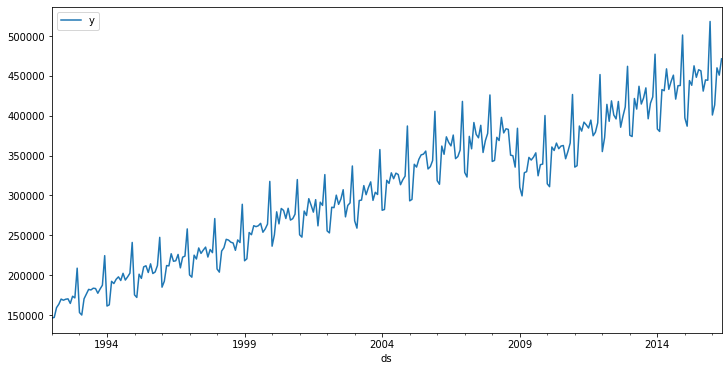

In [11]:
df.plot(figsize=(12,6))

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


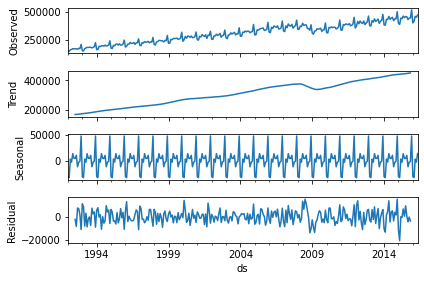

In [14]:
results = seasonal_decompose(df['y'])
results.plot();

In [15]:
len(df)

293

In [16]:
train = df.iloc[:250]
test = df.iloc[250:]

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [18]:
df.head(),df.tail()

(                 y
 ds                
 1992-01-01  146376
 1992-02-01  147079
 1992-03-01  159336
 1992-04-01  163669
 1992-05-01  170068,                  y
 ds                
 2016-01-01  400928
 2016-02-01  413554
 2016-03-01  460093
 2016-04-01  450935
 2016-05-01  471421)

In [19]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [20]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [21]:
# We do the same thing, but now instead for 12 months
n_input = 30
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [26]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [28]:
# fit model
model.fit(generator,epochs=100)

Epoch 1/100
220/220 [==============================] - 4s 14ms/step - loss: 0.0187
Epoch 2/100
220/220 [==============================] - 3s 15ms/step - loss: 0.0083
Epoch 3/100
220/220 [==============================] - 3s 14ms/step - loss: 0.0070
Epoch 4/100
220/220 [==============================] - 3s 14ms/step - loss: 0.0076
Epoch 5/100
220/220 [==============================] - 3s 13ms/step - loss: 0.0065
Epoch 6/100
220/220 [==============================] - 3s 14ms/step - loss: 0.0070
Epoch 7/100
220/220 [==============================] - 3s 14ms/step - loss: 0.0076
Epoch 8/100
220/220 [==============================] - 3s 14ms/step - loss: 0.0068
Epoch 9/100
220/220 [==============================] - 3s 14ms/step - loss: 0.0070
Epoch 10/100
220/220 [==============================] - 3s 15ms/step - loss: 0.0068
Epoch 11/100
220/220 [==============================] - 3s 14ms/step - loss: 0.0073
Epoch 12/100
220/220 [==============================] - 3s 14ms/step - loss: 0.0065
E

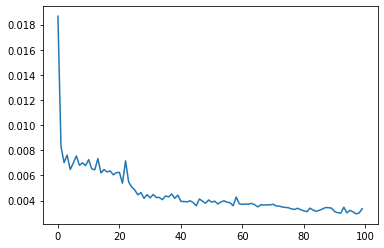

In [29]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [30]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [31]:
true_predictions = scaler.inverse_transform(test_predictions)

In [32]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [33]:
test.head()

,y,Predictions
ds,,
2012-11-01,410992,420797.900709
2012-12-01,461994,408912.899153
2013-01-01,375537,413546.116159
2013-02-01,373938,418661.641492
2013-03-01,421638,415601.799588


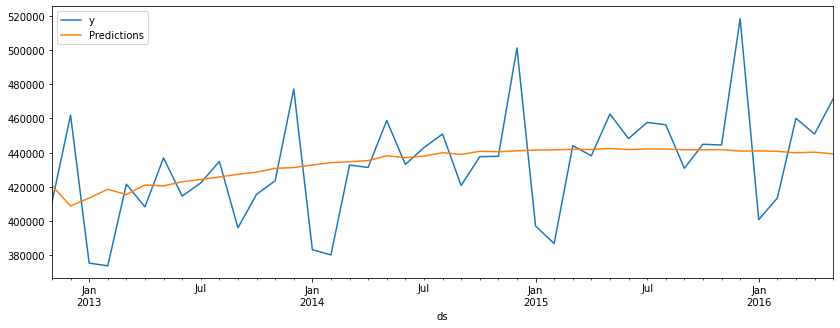

In [34]:
test.plot(figsize=(14,5))

In [36]:
test['APE'] = (test['y'] - test['Predictions']) / test['y'] * 100

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [37]:
test

,y,Predictions,APE
ds,,,
2012-11-01,410992,420797.900709,-2.385910
2012-12-01,461994,408912.899153,11.489565
2013-01-01,375537,413546.116159,-10.121271
2013-02-01,373938,418661.641492,-11.960176
2013-03-01,421638,415601.799588,1.431607
2013-04-01,408381,421162.566200,-3.129814
2013-05-01,436985,420633.400906,3.741913
2013-06-01,414701,423041.485129,-2.011204
2013-07-01,422357,424382.194914,-0.479498


In [38]:
test['APE'].mean()

-0.7472564808944812

In [40]:
test.shape

(43, 3)